The idea of this notebook is to 
1. find the parameters of Parker's sky model that produces the darkest sky
2. compare it to the dark sky model in DESI

parker's sky model only predicts the continuum so one way or another we need to include the sky lines.

In [1]:
import numpy as np 
import astropy.units as u
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky
# -- desi -- 
import desimodel.io
import desisim.simexp

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# parameter values taken from parker's notebook https://github.com/parfa30/BOSS_SkyCont/blob/master/ModelOutput.ipynb
theta_fid = (1.40737998, # airmass 
             10.94289, # ecl latitude
             41.60275, # galactic latitude
             198.8657, # galactic longitude
             4.86761390e+09, # tai
             -29.38102387, # sun altitude
             161.96666204, # sun separation
             2.09588478, # moon phase
             0.24935523, # moon ill
             105.91325896, # moon sep
             29.06037231 # moon alt
            )
sky_fid = Sky.skySpec(*theta_fid)
w, Icont_fid = sky_fid.get_Icontinuum()

/Users/chang/anaconda2/lib/python2.7/site-packages/feasibgs/skymodel.py:215: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  coeffs = pd.DataFrame.from_csv(f)


In [4]:
theta_dark = (1.3,
              30., 
              10., 
              180., 
              4.86761390e+09, 
              -25., 
              150.,
              np.pi, 
              0., 
              140., 
              -21.68
             )
sky_dark = Sky.skySpec(*theta_dark)
w, Icont_dark = sky_dark.get_Icontinuum()

(0.0, 10.0)

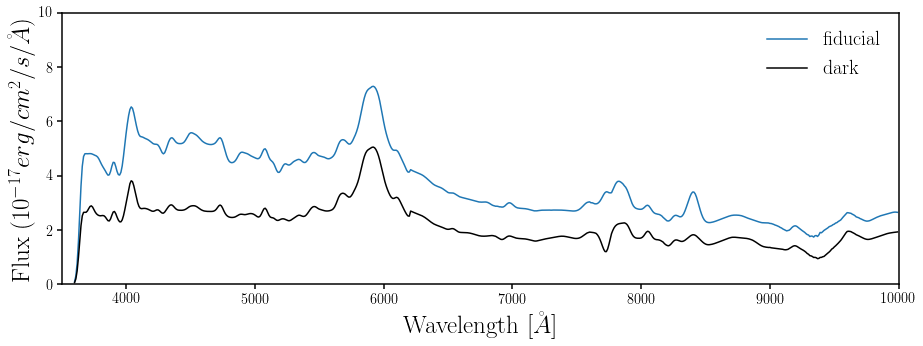

In [5]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(w, Icont_fid, c='C0', label='fiducial')
sub.plot(w, Icont_dark, c='k', label='dark')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"Flux ($10^{-17} erg/cm^{2}/s/\AA$)", fontsize=25)
sub.set_ylim([0., 10.])

In [6]:
# ccd wavelength limit 
params = desimodel.io.load_desiparams() 
wavemin = params['ccd']['b']['wavemin']
wavemax = params['ccd']['z']['wavemax']
print('%f < lambda < %f' % (wavemin, wavemax))

waves = np.linspace(wavemin, wavemax, 1e4) * u.angstrom
config = desisim.simexp._specsim_config_for_wave((waves).to('Angstrom').value, specsim_config_file='desi')

3533.000000 < lambda < 9913.000000


/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


In [7]:
config.verbose = True
surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

Loaded 65000 rows from /Volumes/chang_eHDD/projects/desi/data/spectra/spec-sky.dat with args {'format': 'ascii'}
Loaded 65000 rows from /Volumes/chang_eHDD/projects/desi/data/spectra/spec-sky-bright.dat with args {'format': 'ascii'}
Loaded 65000 rows from /Volumes/chang_eHDD/projects/desi/data/spectra/spec-sky-grey.dat with args {'format': 'ascii'}


(0.0, 10.0)

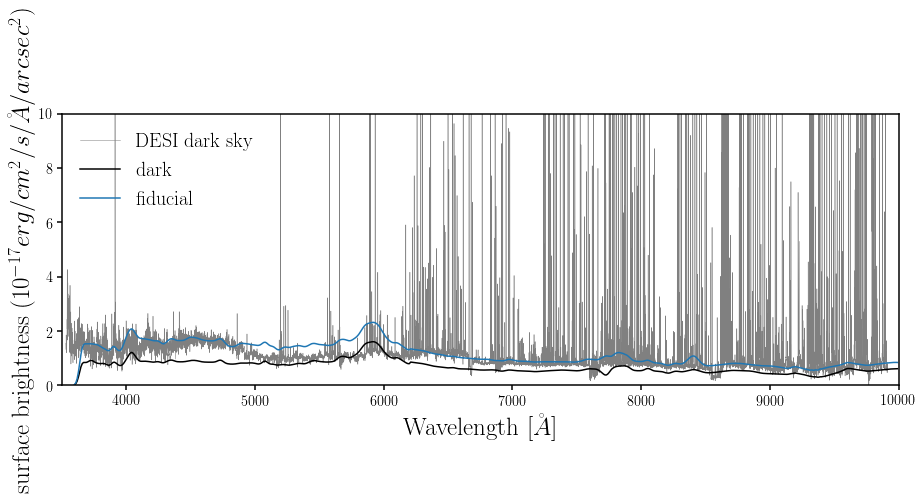

In [10]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(config.wavelength, surface_brightness_dict['dark'].value, c='gray', lw=0.5, label='DESI dark sky')
sub.plot(w, Icont_dark/np.pi, c='k', label='dark')
sub.plot(w, Icont_fid/np.pi, c='C0', label='fiducial')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])



In [11]:
def hanuschik_continuum(w): 
    cont = np.zeros(len(w))
    cont[(w > 3140) & (w < 3760)] = 0.17
    cont[(w > 3760) & (w < 4860)] = 0.14
    cont[(w > 4800) & (w < 5770)] = 0.09
    cont[(w > 5830) & (w < 6790)] = 0.10
    cont[(w > 6700) & (w < 8560)] = 0.08
    cont[(w > 8600) & (w < 10430)] = 0.07    
    return 10.*cont

(0.0, 10.0)

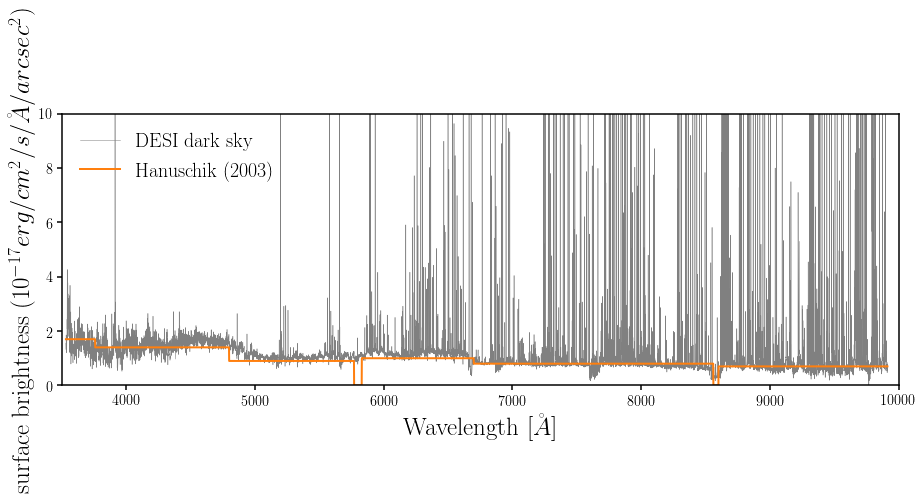

In [12]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(config.wavelength, surface_brightness_dict['dark'].value, c='gray', lw=0.5, label='DESI dark sky')
sub.plot(config.wavelength,hanuschik_continuum(config.wavelength.value), c='C1', lw=2, label='Hanuschik (2003)')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])